In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/CS6890Project/data/training.1600000.processed.noemoticon.csv"

In [5]:
file = open(data_path, "r")
for line in file:
    print(line)
    break
file.close()

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"



In [6]:
data = pd.read_csv(data_path, header=None, encoding = "ISO-8859-1")
data.columns = ["target", "id", "date", "flag", "user", "text"]

In [7]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
X=np.array(data['text'])
Y=np.array(data['target'])
Y[Y==4]=1

In [9]:
index = 3000 
print(X[index])

@islandiva147 I sent u a tweet yesterday but I don't know why it didn't work  I guess you're sleeping right now I am working soon noon !!!


#Data pre-processing

In [17]:
def tokenize(X):
  """
  Tokenize the data using nltk
  """
  treebank = nltk.tokenize.TreebankWordTokenizer()
  X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
  return X_tokenized


def remove_stopwords(X):
  """
  Remove Stopwords using nltk
  """
  stopwords=nltk.corpus.stopwords.words('english') + ['@']
  X_no_stopwords = []
  for sentence in X:
    temp = [word for word in sentence if not word in stopwords]
    X_no_stopwords.append(temp) 
  return X_no_stopwords


In [18]:
def stem(X,type='porter'):
  """
  Perform Stemming using nltk
  type = 'Porter','Snowball','Lancaster'
  """
  if type == 'porter':
    stemmer= nltk.stem.PorterStemmer()
  elif type == 'snowball':
    stemmer = nltk.stem.SnowballStemmer()
  elif type == 'lancaster':
    stemmer = nltk.stem.LancasterStemmer()    
  X_stemmed = []
  for sentence in X:
    temp = [stemmer.stem(word) for word in sentence]
    X_stemmed.append(temp)
  return X_stemmed 


In [19]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'

def lemmatize(X):
  """
  Lemmatize words using corresponding POS tag
  """
  lemmatizer = nltk.stem.WordNetLemmatizer()
  X_pos = []
  X_lemmatized = []

  for sentence in X :
    temp = nltk.pos_tag(sentence)
    X_pos.append(temp)  

  for sentence in X_pos :
    temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in sentence]
    X_lemmatized.append(temp)  
  return X_lemmatized    

In [20]:
X_tokenized = tokenize(X)
X_no_stopwords = remove_stopwords(X_tokenized)
X_lemmatized = lemmatize(X_no_stopwords)
X_clean = []
for sentence in X_lemmatized:
  temp = " ".join(sentence)
  X_clean.append(temp)

In [21]:
max_vocab=50000

In [22]:
tokenizer = Tokenizer(num_words=max_vocab,filters='@')
tokenizer.fit_on_texts(X_clean)

In [23]:
# Vectorize
X_clean_vectorized=tokenizer.texts_to_sequences(X_clean)

In [24]:
max_length=20

In [25]:
X_clean_pad = keras.preprocessing.sequence.pad_sequences(X_clean_vectorized,max_length,padding='post',truncating='post')
print(X_clean_pad.shape)

(1600000, 20)


In [26]:
index  = 3000  

print('\nOriginal text:')
print(X[index])
print('\nTokenized :')
print(X_tokenized[index])
print('\nStopwords removed :')
print(X_no_stopwords[index])
print('\nPOS tagged :')
print(nltk.pos_tag(X_no_stopwords[index]))
print('\nLemmatized :')
print(X_lemmatized[index])
print('\nClean :')
print(X_clean[index])
print('\nVectorized :')
print(X_clean_vectorized[index])
print('\nPadded :')
print(X_clean_pad[index])


Original text:
@islandiva147 I sent u a tweet yesterday but I don't know why it didn't work  I guess you're sleeping right now I am working soon noon !!!

Tokenized :
['@', 'islandiva147', 'I', 'sent', 'u', 'a', 'tweet', 'yesterday', 'but', 'I', 'do', "n't", 'know', 'why', 'it', 'did', "n't", 'work', 'I', 'guess', 'you', "'re", 'sleeping', 'right', 'now', 'I', 'am', 'working', 'soon', 'noon', '!', '!', '!']

Stopwords removed :
['islandiva147', 'I', 'sent', 'u', 'tweet', 'yesterday', 'I', "n't", 'know', "n't", 'work', 'I', 'guess', "'re", 'sleeping', 'right', 'I', 'working', 'soon', 'noon', '!', '!', '!']

POS tagged :
[('islandiva147', 'NN'), ('I', 'PRP'), ('sent', 'VBD'), ('u', 'JJ'), ('tweet', 'NN'), ('yesterday', 'NN'), ('I', 'PRP'), ("n't", 'RB'), ('know', 'VBP'), ("n't", 'RB'), ('work', 'VB'), ('I', 'PRP'), ('guess', 'JJ'), ("'re", 'VBP'), ('sleeping', 'VBG'), ('right', 'RB'), ('I', 'PRP'), ('working', 'VBG'), ('soon', 'RB'), ('noon', 'RB'), ('!', '.'), ('!', '.'), ('!', '.')]



#WordEmbeddings

**Using pre-trained Word Embeddings (GloVe)**

In [ ]:
embedding_path = "/content/drive/MyDrive/CS6890Project/data/glove.6B.100d.txt"

In [ ]:
emb = dict()
f = open(embedding_path)
for line in f:
	values = line.split()
	word = values[0]
	cf = np.asarray(values[1:], dtype='float32')
	emb[word] = cf
f.close()

In [ ]:
embedding_matrix = np.zeros((max_vocab, 100))
for i in range(1,max_vocab):
	vector = emb.get(tokenizer.index_word[i])
	if vector is not None:
		embedding_matrix[i] = vector

In [ ]:
np.random.seed(42)

X_train, X_test, Y_train, Y_test = train_test_split (X_clean_pad,Y.reshape(Y.shape[0],1),test_size=0.30)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1120000, 20)
(480000, 20)
(1120000, 1)
(480000, 1)


#Attention Layer

In [ ]:
 import numpy as np
 from keras.preprocessing import sequence
 from keras.models import Sequential
 from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
 from keras.datasets import imdb 

In [ ]:
from keras.layers import *
from keras.models import *
from keras import backend as K

In [ ]:
n_unique_words = 10000
maxlen = 200

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))

        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
max_len = 20
max_words = 50000
emb_dim = 128

In [ ]:
att_model = keras.models.Sequential(name='att_model')

att_model.add(InputLayer(input_shape=(20,),name = 'Integer_Encoding'))
att_model.add(Embedding(max_vocab, 100,input_length=20,mask_zero=True,name='100D_Encoding',trainable=False))
att_model.add(Bidirectional(LSTM(64,name='LSTM'),name='Bidirectional_RNN'))
att_model.add(Attention(return_sequences=True))
att_model.add(Dropout(0.5,name='Regularizer'))
att_model.add(Dense(1, activation='sigmoid',name='Sigmoid_Classifier'))


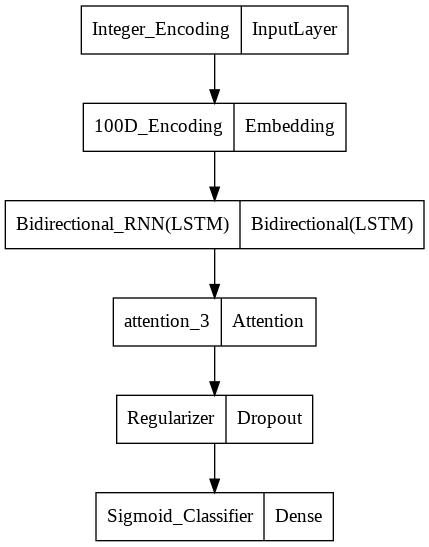

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(att_model,to_file='model.png')

In [ ]:
np.random.seed(123)
#X_train: X1, X_test: X2, Y_train:Y1, Y_test:Y2

X1, X2, Y1, Y2 = train_test_split (X_clean_pad,Y.reshape(Y.shape[0],1),test_size=0.30)

print(len(X1))
print(len(X2))
print(len(Y1))
print(len(Y2))

1120000
480000
1120000
480000


In [ ]:
att_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',
                metrics=['accuracy'])
att_model


In [ ]:
att_model = att_model.fit(X1,Y1,batch_size=128,epochs=10,validation_split=0.30)

Epoch 1/10
6125/6125 [==============================] - 556s 90ms/step - loss: 0.6182 - accuracy: 0.6526 - val_loss: 0.5834 - val_accuracy: 0.6827
Epoch 2/10
6125/6125 [==============================] - 549s 90ms/step - loss: 0.5663 - accuracy: 0.6989 - val_loss: 0.5437 - val_accuracy: 0.7174
Epoch 3/10
6125/6125 [==============================] - 516s 84ms/step - loss: 0.5389 - accuracy: 0.7218 - val_loss: 0.5267 - val_accuracy: 0.7311
Epoch 4/10
6125/6125 [==============================] - 496s 81ms/step - loss: 0.5230 - accuracy: 0.7347 - val_loss: 0.5176 - val_accuracy: 0.7399
Epoch 5/10
6125/6125 [==============================] - 488s 80ms/step - loss: 0.5118 - accuracy: 0.7434 - val_loss: 0.5173 - val_accuracy: 0.7390
Epoch 6/10
6125/6125 [==============================] - 488s 80ms/step - loss: 0.5031 - accuracy: 0.7496 - val_loss: 0.5003 - val_accuracy: 0.7512
Epoch 7/10
6125/6125 [==============================] - 488s 80ms/step - loss: 0.4969 - accuracy: 0.7542 - val_loss: 0

In [ ]:
att_model.params

{'epochs': 10, 'steps': 6125, 'verbose': 1}

In [ ]:
att_model.history

{'accuracy': [0.6525701284408569,
  0.6988711953163147,
  0.7217869758605957,
  0.7347449064254761,
  0.7434477210044861,
  0.7495625019073486,
  0.7541581392288208,
  0.7577563524246216,
  0.7613252401351929,
  0.7647678852081299],
 'loss': [0.61822909116745,
  0.5662626028060913,
  0.538870096206665,
  0.5230321884155273,
  0.5117695927619934,
  0.5031116604804993,
  0.49688851833343506,
  0.4913395345211029,
  0.48676252365112305,
  0.4820605218410492],
 'val_accuracy': [0.6827232241630554,
  0.7174196243286133,
  0.7310506105422974,
  0.739934504032135,
  0.7390416860580444,
  0.7512142658233643,
  0.7529642581939697,
  0.7573065757751465,
  0.7605594992637634,
  0.7624910473823547],
 'val_loss': [0.5833690762519836,
  0.5437344908714294,
  0.5266674757003784,
  0.5175577998161316,
  0.5172863006591797,
  0.5003176331520081,
  0.49763545393943787,
  0.49264758825302124,
  0.4871337413787842,
  0.48677632212638855]}

In [ ]:
att_model.evaluate(X2,Y2)